# Salary survey analysis- EDA
- Train a predictive model to predict salary from information about the employee's job title, job position, years of experience etc...
- Identify the most salient determinants of salary
- The dependent variable in this dataset is "annual_salary", which is a continuous variable. Therefore, we have a regression problem.
- This notebook will focus primarily on exploring the dataset

In [1]:
import sys
import os
from pathlib import Path
from collections import defaultdict

'''data'''
import pandas as pd
import numpy as np

'''visualization'''
import matplotlib.pyplot as plt
import seaborn as sns

'''sklearn'''
from sklearn.preprocessing import LabelEncoder

'''stats'''
from scipy.stats import chi2_contingency

sns.set_theme(style="whitegrid")

In [2]:
# set working directory to be one level above /notebook during the INIT RUN 
try: INIT_RUN
except NameError:
    os.chdir(os.path.dirname(os.getcwd()))
    INIT_RUN=True

**Pathnames**

In [3]:
# get root and data directory of project
ROOT_DIR = os.getcwd()
RAW_DATA_DIR = Path(ROOT_DIR,"data","raw")

## Import data

In [4]:
survey = pd.read_csv(Path(RAW_DATA_DIR,"survey.csv"))

**Get some basic information about the data**

In [5]:
print(f"There are {survey.shape[0]} rows and {survey.shape[1]} columns in the dataset.")

There are 26232 rows and 18 columns in the dataset.


In [6]:
survey.sample(5)

,timestamp,how_old_are_you,industry,job_title,additional_context_on_job_title,annual_salary,other_monetary_comp,currency,currency_other,additional_context_on_income,country,state,city,overall_years_of_professional_experience,years_of_experience_in_field,highest_level_of_education_completed,gender,race
4518,4/27/2021 12:37:28,45-54,Government and Public Administration,Communications Specialist,NaN,76000,NaN,USD,NaN,NaN,US,Wisconsin,Madison,21 - 30 years,11 - 20 years,Master's degree,Woman,White
4275,4/27/2021 12:29:38,25-34,Law,Paralegal,Immigration Law,70210,15000.0,USD,NaN,NaN,United States,California,Santa Clara,2 - 4 years,5-7 years,College degree,Woman,White
15402,4/28/2021 17:05:56,35-44,Life Sciences,Senior statistical analytical programmwr,NaN,69000,20000.0,GBP,NaN,NaN,Uk,NaN,London,11 - 20 years,5-7 years,PhD,Man,White
9200,4/27/2021 17:25:08,25-34,Government and Public Administration,Director of Policy,I work at a public housing authority,107000,0.0,USD,NaN,NaN,United States,California,NaN,8 - 10 years,5-7 years,Master's degree,Woman,"Asian or Asian American, White"
8650,4/27/2021 16:25:55,45-54,Computing or Tech,Developer,ERP system programmer,240000,12000.0,Other,ILS/NIS,Plus car and running costs,Israel,NaN,Hod Hasharon,11 - 20 years,11 - 20 years,College degree,Man,Another option not listed here or prefer not t...


In [7]:
survey.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26232 entries, 0 to 26231
Data columns (total 18 columns):
 #   Column                                    Non-Null Count  Dtype  
---  ------                                    --------------  -----  
 0   timestamp                                 26232 non-null  object 
 1   how_old_are_you                           26232 non-null  object 
 2   industry                                  26173 non-null  object 
 3   job_title                                 26232 non-null  object 
 4   additional_context_on_job_title           6763 non-null   object 
 5   annual_salary                             26232 non-null  int64  
 6   other_monetary_comp                       19447 non-null  float64
 7   currency                                  26232 non-null  object 
 8   currency_other                            166 non-null    object 
 9   additional_context_on_income              2872 non-null   object 
 10  country                           

In [8]:
survey.describe(include=["float","int"])

,annual_salary,other_monetary_comp
count,2.623200e+04,1.944700e+04
mean,1.457254e+05,1.848935e+04
std,5.543526e+06,8.616672e+05
min,0.000000e+00,0.000000e+00
25%,5.400000e+04,0.000000e+00
50%,7.600000e+04,2.000000e+03
75%,1.100000e+05,1.000000e+04
max,8.700000e+08,1.200000e+08


We want to predict employee's base salary, so we will most likely ignore other compensation. From "max", there could be some outliers that we should remove from annual_salary.

In [9]:
survey.describe(include=["O"])

,timestamp,how_old_are_you,industry,job_title,additional_context_on_job_title,currency,currency_other,additional_context_on_income,country,state,city,overall_years_of_professional_experience,years_of_experience_in_field,highest_level_of_education_completed,gender,race
count,26232,26232,26173,26232,6763,26232,166,2872,26232,21545,26154,26232,26232,26036,26084,26086
unique,23454,7,1068,12622,6479,11,99,2804,294,124,4009,8,8,6,5,47
top,4/27/2021 11:24:33,25-34,Computing or Tech,Software Engineer,Fundraising,USD,USD,Base salary + commission,United States,California,Boston,11 - 20 years,11 - 20 years,College degree,Woman,White
freq,5,11748,4360,289,23,21852,10,4,9010,2436,794,9139,6245,12584,20359,21909


Many levels for some columns such as job_title, country, city, state (>51) and race could be 1) open response, and/or 2) multiple selection questions since there are relatively high number of levels.

In [10]:
# convert timestamp to a datetime variable
survey["timestamp"].dtype

dtype('O')

In [11]:
# can reformat timestamp column with an additional arugment
# format='%y%m%d%h%m%s' 
survey["timestamp"]=pd.to_datetime(survey['timestamp'])

## Data processing
- Identify data processing steps for features that might be of interest in predicting annual_salary
- I can implement some of these data processing steps with custom functions for now (to be used in EDA). Later on, we will replace these custom functions with skelarn/feature-engine transformers in a data processing pipeline. 

In [12]:
cat_vars = [var for var in survey.columns if survey[var].dtype=='O']
cat_vars

['how_old_are_you',
 'industry',
 'job_title',
 'additional_context_on_job_title',
 'currency',
 'currency_other',
 'additional_context_on_income',
 'country',
 'state',
 'city',
 'overall_years_of_professional_experience',
 'years_of_experience_in_field',
 'highest_level_of_education_completed',
 'gender',
 'race']

In [13]:
num_vars = [var for var in survey.columns if survey[var].dtype!='O']
num_vars

['timestamp', 'annual_salary', 'other_monetary_comp']

### Currrency

In [14]:
survey["currency"].value_counts(normalize=True)

USD        0.833028
CAD        0.059622
GBP        0.057983
EUR        0.022301
AUD/NZD    0.017879
Other      0.005070
CHF        0.001334
SEK        0.001296
JPY        0.000839
ZAR        0.000496
HKD        0.000152
Name: currency, dtype: float64

Mostly USD, a small percentage of respondents are paid in CAD, or GBP (10% in total). Let's just consider respondents who are paid in USD.

In [15]:
# filter respondents who are paid in USD
survey_usd = survey.loc[survey["currency"]=='USD']

## Check for outliers in the depedent variable
- I want to see if there are outliers for annual salary
- It is likely that the outliers are naturally occuring-- in that there are people who actually make very high/low salary
- I will be conservative when removing outliers
    - On the lower end, an extreme outlier is first quartile -3 IQR
    - Higher end, and extreme outlier is third qaurtile + 3 IQR

In [16]:
quartile_1 = survey_usd["annual_salary"].describe().loc["25%"]
quartile_3 = survey_usd["annual_salary"].describe().loc["75%"]
IQR = quartile_3-quartile_1

upr = quartile_3+3*IQR
lwr = 5000 # quartile_1-3*IQR

# Remove outliers
survey_usd = (survey_usd
                  .loc[survey_usd["annual_salary"].between(lwr,upr)])

In [17]:
survey_usd.shape #down from 26000 observations

(21583, 18)

### Extent of missing values

In [18]:
# categorical variables
survey_usd.loc[:,cat_vars].isna().mean().sort_values(ascending=False)

currency_other                              0.999166
additional_context_on_income                0.892045
additional_context_on_job_title             0.737664
state                                       0.014873
highest_level_of_education_completed        0.006209
race                                        0.005745
gender                                      0.005653
city                                        0.002734
industry                                    0.002131
how_old_are_you                             0.000000
job_title                                   0.000000
currency                                    0.000000
country                                     0.000000
overall_years_of_professional_experience    0.000000
years_of_experience_in_field                0.000000
dtype: float64

Since I am only focusing on respondents who are earning USD. I can ignore currency_other. The additional context variables might not be worthwhile to be included as features, given the very high percentage of missing values. Very small (<5%) percentage of missing values in state, education, race, gender.... I can either impute with mode, or drop missing values.

In [19]:
survey_usd.loc[:,num_vars].isna().mean().sort_values(ascending=False)

other_monetary_comp    0.249826
timestamp              0.000000
annual_salary          0.000000
dtype: float64

Likely won't use other_monetary_comp as I am only interested in predicting employees' base salary.

### Geographic location

In [20]:
survey_usd["country"].value_counts(sort=True, normalize=True)

United States               0.413010
USA                         0.361674
US                          0.113191
U.S.                        0.025900
United States of America    0.019599
                              ...   
Uniteed States              0.000046
USS                         0.000046
U.s.a.                      0.000046
Virginia                    0.000046
South africa                0.000046
Name: country, Length: 185, dtype: float64

It seems that country is an open response question: I see multiple ways of writing United States.

In [21]:
survey_usd["state"].value_counts(normalize=True, sort=True)

California                 0.111984
New York                   0.094206
Massachusetts              0.067726
Texas                      0.054510
Illinois                   0.052253
                             ...   
Nevada, Oregon             0.000047
New Jersey, Virginia       0.000047
Montana, Wyoming           0.000047
Colorado, Massachusetts    0.000047
Oregon, Washington         0.000047
Name: state, Length: 124, dtype: float64

In [22]:
(survey_usd["state"]
     .value_counts()
     .nsmallest(5))

California, Texas                   1
Indiana, Ohio                       1
Florida, Georgia, South Carolina    1
Iowa, Utah, Vermont                 1
Georgia, Massachusetts              1
Name: state, dtype: int64

There are 124 states, this is because state is also an open response question. Some people can enter multiple states. I am assuming the first state the respondent enters is his/her "primary" location. For simplicity, We can consider each respondent's primary state and ignore the rest.

In [23]:
# Only take the first state in the response and ignore the rest
survey_usd["state"]=survey_usd["state"].str.split(',').str[0]

In [24]:
len(survey_usd["state"].unique()) # 52 states (51 states + DC)

52

In [25]:
survey_usd["city"].value_counts()

Boston                                                   784
Chicago                                                  753
New York                                                 723
Seattle                                                  683
San Francisco                                            531
                                                        ... 
Rural California                                           1
Boulder but we are remote                                  1
Cerritos                                                   1
Clarendon Hills                                            1
NA (work from home in small town, decline to specify)      1
Name: city, Length: 3250, dtype: int64

In [26]:
survey_usd["city"].value_counts().nsmallest(10)

Los Angeles area            1
Belo Horizonte              1
Los Altos                   1
Cheraw                      1
Commerce                    1
Upper Penninsula            1
Orange county               1
Greeley surrounding area    1
rural area                  1
Westerville                 1
Name: city, dtype: int64

City is an open response (since there are incorrect spellings), but respondents seem to only enter one city (unlike state, where there are multiple responses). **Consider lumping rare levels to "others" and only retaining the first n most common levels. Also apply this to states.** We need to do this since when we one-hot encode these nominal variables, we want to minimize the number of levels.

In [27]:
# config parameters
n_state_retain = 10 # retain the first 10 common states, label the rest as others
n_city_retain = 10 # retain the first 10 common cities, label the rest as others

In [28]:
top_n = survey_usd["state"].value_counts().index[:n_state_retain]
top_n

Index(['California', 'New York', 'Massachusetts', 'Texas', 'Illinois',
       'Washington', 'District of Columbia', 'Pennsylvania', 'Virginia',
       'Minnesota'],
      dtype='object')

In [29]:
survey_usd["state"].where(survey_usd["state"].isin(top_n),
                "Other")

0        Massachusetts
2                Other
3                Other
4                Other
5                Other
             ...      
26227         New York
26228     Pennsylvania
26229       California
26230       Washington
26231            Other
Name: state, Length: 21583, dtype: object

In [30]:
# Let's encapsulate the above in a function
def fct_lump(df_in,col,n_retain, rare_label="Other"):
    df = df_in.copy() # make a copy of the input dataframe
    
    # compute the top n levels in a column to retain
    top_n = df[col].value_counts().index[:n_retain]
    
    # relabel column-- retain the top n levels, and relabel the rest of the labels to "Other"
    df[col] = df[col].where(df[col].isin(top_n),
                rare_label)
    
    return df

In [31]:
(fct_lump(df_in=survey_usd,
         col= "state",
         n_retain=n_state_retain)
     .state
     .value_counts())

Other                   9150
California              2393
New York                2005
Massachusetts           1446
Texas                   1160
Illinois                1114
Washington              1104
District of Columbia     944
Pennsylvania             873
Virginia                 726
Minnesota                668
Name: state, dtype: int64

In [32]:
survey_usd=fct_lump(df_in=survey_usd,
         col= "state",
         n_retain=n_state_retain)

In [33]:
# Apply the function to the "city" column
(fct_lump(df_in=survey_usd,
         col= "city",
         n_retain=n_city_retain)
     .city
     .value_counts())

Other            15994
Boston             784
Chicago            753
New York           723
Seattle            683
San Francisco      531
New York City      478
Los Angeles        470
Portland           448
Minneapolis        360
Washington         359
Name: city, dtype: int64

In [34]:
survey_usd=fct_lump(df_in=survey_usd,
         col= "city",
         n_retain=n_city_retain)

In [112]:
(fct_lump(df_in=survey_usd,
         col= "state",
         n_retain=n_state_retain)
     .state
     .value_counts())

Other                   9818
California              2393
New York                2005
Massachusetts           1446
Texas                   1160
Illinois                1114
Washington              1104
District of Columbia     944
Pennsylvania             873
Virginia                 726
Name: state, dtype: int64

### Years of experience

In [35]:
survey_usd["overall_years_of_professional_experience"].value_counts()

11 - 20 years       7613
8 - 10 years        4132
5-7 years           3670
21 - 30 years       2866
2 - 4 years         2180
31 - 40 years        677
1 year or less       341
41 years or more     104
Name: overall_years_of_professional_experience, dtype: int64

- There are some levels with 11 - 20 years and other with 5-7 years. We need to fix this.
- We should make this into an ordered categorical variable, parsed by the first numeric number

In [36]:
survey_usd['overall_years_of_professional_experience'] = (survey_usd['overall_years_of_professional_experience']
                                                      .str
                                                      .replace(' - ','-'))

In [37]:
ordered_levels = (survey_usd['overall_years_of_professional_experience']
    .value_counts()
    .reset_index()
    .rename(columns={'index':'levels'})
     # extract the first one (or more) digits
    .assign(num_levels=lambda x: x.levels.str.extract(r'(\d+)').astype(int))
    .sort_values("num_levels")
    .levels
    .tolist())

ordered_levels

['1 year or less',
 '2-4 years',
 '5-7 years',
 '8-10 years',
 '11-20 years',
 '21-30 years',
 '31-40 years',
 '41 years or more']

In [38]:
# Let's try putting the above as a function since we will be using this a few times
def parse_num_get_levels(df,col):
    ordered_levels = (df[col]
    .value_counts()
    .reset_index()
    .rename(columns={'index':'levels'})
     # extract the first one (or more) digits
    .assign(num_levels=lambda x: x.levels.str.extract(r'(\d+)').astype(int))
    .sort_values("num_levels")
    .levels
    .tolist())
    
    # create categorical type
    categorical_type =  pd.api.types.CategoricalDtype(
    categories=ordered_levels,
    ordered=True)
    
    # convert col to ordered categorical type
    df[col] = df[col].astype(categorical_type)

In [39]:
parse_num_get_levels(survey_usd,
                     "overall_years_of_professional_experience")

In [40]:
survey_usd["overall_years_of_professional_experience"]

0          5-7 years
2          2-4 years
3         8-10 years
4         8-10 years
5         8-10 years
            ...     
26227      5-7 years
26228    11-20 years
26229    11-20 years
26230      2-4 years
26231    11-20 years
Name: overall_years_of_professional_experience, Length: 21583, dtype: category
Categories (8, object): ['1 year or less' < '2-4 years' < '5-7 years' < '8-10 years' < '11-20 years' < '21-30 years' < '31-40 years' < '41 years or more']

**Using the same approach, convert "years_of_experience_in_field" to an ordered categorical variable**

In [41]:
survey_usd["years_of_experience_in_field"].value_counts().sort_values(ascending=False)

11 - 20 years       5187
5-7 years           5070
2 - 4 years         4595
8 - 10 years        3938
21 - 30 years       1461
1 year or less       988
31 - 40 years        312
41 years or more      32
Name: years_of_experience_in_field, dtype: int64

**Most people have 11-20 years of experience in field, followed by 5-7 years**

In [42]:
survey_usd['years_of_experience_in_field'] = (survey_usd['years_of_experience_in_field']
                                                      .str
                                                      .replace(' - ','-'))

In [43]:
survey_usd["years_of_experience_in_field"].value_counts()

11-20 years         5187
5-7 years           5070
2-4 years           4595
8-10 years          3938
21-30 years         1461
1 year or less       988
31-40 years          312
41 years or more      32
Name: years_of_experience_in_field, dtype: int64

In [44]:
parse_num_get_levels(survey_usd,
                     "years_of_experience_in_field")

In [45]:
survey_usd["years_of_experience_in_field"]

0          5-7 years
2          2-4 years
3          5-7 years
4          5-7 years
5          2-4 years
            ...     
26227      5-7 years
26228      2-4 years
26229    11-20 years
26230      2-4 years
26231     8-10 years
Name: years_of_experience_in_field, Length: 21583, dtype: category
Categories (8, object): ['1 year or less' < '2-4 years' < '5-7 years' < '8-10 years' < '11-20 years' < '21-30 years' < '31-40 years' < '41 years or more']

We can put this function as a custom transformer later on so that I can include this as a step in my data processing sklearn pipeline.

### Age

In [46]:
survey_usd["how_old_are_you"].value_counts()

25-34         9549
35-44         7800
45-54         2519
18-24          823
55-64          802
65 or over      81
under 18         9
Name: how_old_are_you, dtype: int64

Again, I can set this as an ordered categorical variable

In [47]:
# Need to rename the "under 18" level to "17 or under" so it can be parsed by my function
survey_usd["how_old_are_you"]=survey_usd["how_old_are_you"].replace(to_replace = "under 18",
                                                                   value="17 or under")

In [48]:
survey_usd["how_old_are_you"].value_counts()

25-34          9549
35-44          7800
45-54          2519
18-24           823
55-64           802
65 or over       81
17 or under       9
Name: how_old_are_you, dtype: int64

**I have most people in the 25-34 and 35-44 age group**

In [49]:
parse_num_get_levels(survey_usd,
                     "how_old_are_you")

In [50]:
survey_usd=survey_usd.rename(columns={"how_old_are_you": "age_category"}, errors="raise")

In [51]:
survey_usd["age_category"]

0        25-34
2        25-34
3        25-34
4        25-34
5        25-34
         ...  
26227    25-34
26228    35-44
26229    25-34
26230    25-34
26231    35-44
Name: age_category, Length: 21583, dtype: category
Categories (7, object): ['17 or under' < '18-24' < '25-34' < '35-44' < '45-54' < '55-64' < '65 or over']

### Race

In [52]:
survey_usd.race.value_counts(sort=True, normalize=True).iloc[:5]

White                                                     0.837830
Asian or Asian American                                   0.045435
Black or African American                                 0.025351
Hispanic, Latino, or Spanish origin                       0.021623
Another option not listed here or prefer not to answer    0.019293
Name: race, dtype: float64

In [53]:
print(f"There are {round(100*survey_usd.race.isna().mean(),2)} % missing for race.")

There are 0.57 % missing for race.


Vast majority are White, following by a few small groups (all <5%): Asian, Black, Hispanic, prefer not to answer. A small number of people identify themselves with multiple race. I will classify them as Others along with people with NA.

In [54]:
# coalesce all NA to "Other"
survey_usd["race"]=survey_usd["race"].fillna("Other")

In [55]:
n_race_retain = 4

# retain the 4 most common race, lump the rest of the levels to "Other"
(fct_lump(df_in=survey_usd,
         col= "race",
         n_retain=n_race_retain)
     .race
     .value_counts())

White                                  17979
Other                                   1621
Asian or Asian American                  975
Black or African American                544
Hispanic, Latino, or Spanish origin      464
Name: race, dtype: int64

In [56]:
survey_usd=fct_lump(df_in=survey_usd,
         col= "race",
         n_retain=n_race_retain)

### Gender

In [57]:
survey_usd.gender.isna().mean()

0.005652596951304267

In [58]:
survey_usd.gender.value_counts(sort=True)

Woman                            17024
Man                               3656
Non-binary                         565
Other or prefer not to answer      215
Prefer not to answer                 1
Name: gender, dtype: int64

First, coalesce all NA to "Other or prefer not to answer". Next retain only Woman and Man (the top 2 most common levels and lump the remaining level to "Other or prefer not to answer"

In [59]:
survey_usd["gender"] = survey_usd["gender"].fillna("Other or prefer not to answer")  

In [60]:
n_gender_retain = 2

# lump the rare levels to "Other"
(fct_lump(df_in=survey_usd,
         col= "gender",
         n_retain=n_gender_retain,
         rare_label = "Other or prefer not to answer")
     .gender
     .value_counts())

Woman                            17024
Man                               3656
Other or prefer not to answer      903
Name: gender, dtype: int64

In [61]:
survey_usd=fct_lump(df_in=survey_usd,
         col= "gender",
         n_retain=n_gender_retain,
         rare_label = "Other or prefer not to answer")

### Education

In [62]:
survey_usd["highest_level_of_education_completed"].value_counts(sort=True, normalize=True)

College degree                        0.489067
Master's degree                       0.328827
Some college                          0.068255
PhD                                   0.049513
Professional degree (MD, JD, etc.)    0.047695
High School                           0.016644
Name: highest_level_of_education_completed, dtype: float64

In [63]:
survey_usd["highest_level_of_education_completed"].isna().mean()

0.006208590094055506

Use this variable as is, imputed NA with "unknown"

In [64]:
survey_usd["education"] = survey_usd["highest_level_of_education_completed"].fillna("Unknown")

### Industry

In [65]:
survey_usd["industry"].value_counts(sort=True, normalize=True)

Computing or Tech                0.159818
Nonprofits                       0.095510
Education (Higher Education)     0.093049
Health care                      0.068440
Accounting, Banking & Finance    0.063983
                                   ...   
Aerospace/Aviation               0.000046
I work for Indeed.com            0.000046
Archives/Library Science         0.000046
Geospatial                       0.000046
Landscaping                      0.000046
Name: industry, Length: 913, dtype: float64

In [66]:
survey_usd["industry"].isna().mean()

0.0021313070472130844

Industry is an open response variable, along with some fixed categories. I can lump all rare levels to others and retain the first 10 most common levels.

In [67]:
survey_usd["industry"]= survey_usd["industry"].fillna("Other")

In [68]:
n_industry_retain = 10

# lump the rare levels to "Other"
(fct_lump(df_in=survey_usd,
         col= "industry",
         n_retain=n_industry_retain)
     .industry
     .value_counts())

Other                                   6143
Computing or Tech                       3442
Nonprofits                              2057
Education (Higher Education)            2004
Health care                             1474
Accounting, Banking & Finance           1378
Government and Public Administration    1368
Engineering or Manufacturing            1287
Law                                      873
Marketing, Advertising & PR              869
Education (Primary/Secondary)            688
Name: industry, dtype: int64

In [69]:
survey_usd=fct_lump(df_in=survey_usd,
         col= "industry",
         n_retain=n_industry_retain,
         rare_label = "Other")

### Job title

In [70]:
survey_usd["job_title"].value_counts(sort=True, normalize=True)

Software Engineer               0.010842
Project Manager                 0.008803
Director                        0.008386
Senior Software Engineer        0.007506
Librarian                       0.006579
                                  ...   
Administrative professional     0.000046
Conservation Ecologist          0.000046
Senior Cataloging Librarian     0.000046
Advisory Software Engineer      0.000046
Knowledge Management Manager    0.000046
Name: job_title, Length: 10568, dtype: float64

In [71]:
survey_usd["job_title"].isna().mean()

0.0

There are 10631 job titles. This could be an open response question with some fixed categories. I will lump all rare levels to "Other" while only retain the first 20 most common levels.

In [72]:
n_job_title_retain = 20

# lump the rare levels to "Other"
(fct_lump(df_in=survey_usd,
         col= "job_title",
         n_retain=n_job_title_retain)
     .job_title
     .value_counts())

Other                       19243
Software Engineer             234
Project Manager               190
Director                      181
Senior Software Engineer      162
Librarian                     142
Program Manager               136
Teacher                       136
Executive Assistant           126
Manager                       115
Administrative Assistant      109
Attorney                      101
Product Manager               100
Office Manager                 85
Paralegal                      80
Data Analyst                   79
Executive Director             77
Associate                      74
Assistant Professor            72
Analyst                        71
Marketing Manager              70
Name: job_title, dtype: int64

In [73]:
survey_usd=fct_lump(df_in=survey_usd,
         col= "job_title",
         n_retain=n_job_title_retain,
         rare_label = "Other")

## Exploratory analysis
- Look at the distribution of the dependent variable
- Look for relationship between features and the dependent variable
- Correlation between features and dependent variable and amongst the features (pairplot and correlation matrix)

### distribution of annual salary

log transform annual salary (need to remove 0 first)

In [74]:
survey_usd=survey_usd.loc[survey_usd["annual_salary"]!=0]
survey_usd["log_annual_salary"] = np.log(survey_usd["annual_salary"])

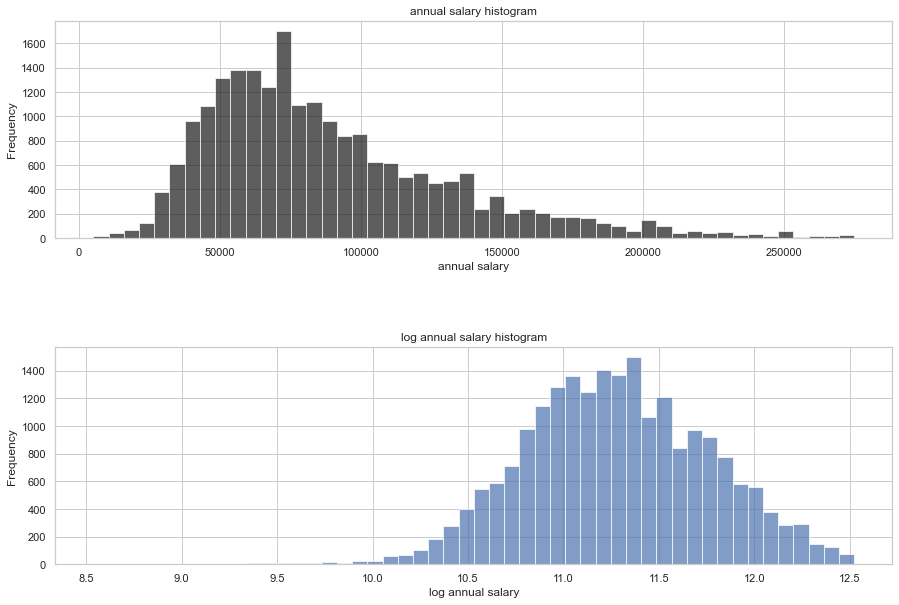

In [75]:
fig,axes = plt.subplots(2,1,
                       figsize = (15,10))
survey_usd["annual_salary"].plot.hist(ax=axes[0],
                                      color = 'k',
                                      alpha=0.7,
                                      bins =50,
                                      title = "annual salary histogram")
axes[0].set_xlabel('annual salary')

survey_usd["log_annual_salary"].plot.hist(ax=axes[1],
                                          color='b',
                                          alpha = 0.7,
                                          bins = 50,
                                          title = "log annual salary histogram")
axes[1].set_xlabel('log annual salary')

# adjust space between plots
plt.subplots_adjust(wspace=0.5, hspace=0.5)

- Annual salary is right skewed with long tail. After transforming it with log, it is more normal (compress far apart salary and spread out the ones that are close to each other).
- I would transform the response variable if non-normal error and/or non-common Var(u) are the ONLY problems with the model AND nonlinearity is NOT a problem.

### annual salary X state
- Boxplot of annual salary for each state categories
- Compute the median annual salary for each state and create barplot (use median since it is robust to outliers)

In [76]:
# order levels of state by median salary
rank = (survey_usd
        .loc[survey_usd["annual_salary"]<1e5]
        .groupby("state")
        .annual_salary
        .median()
        .sort_values(ascending=False)
        .index)

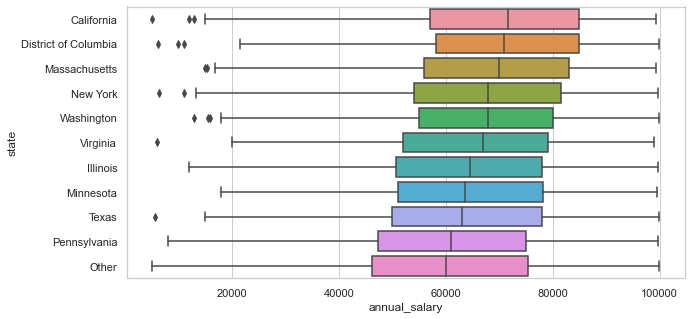

In [77]:
fig = plt.figure(figsize=(10,5))
ax1=fig.add_subplot(1,1,1)

# Using seaborn
ax1=sns.boxplot(x="annual_salary",
                y="state",
                data = (survey_usd
                        .loc[survey_usd["annual_salary"]<1e5]),
                order = rank)

There seems to be a correlation between states and annual salary as there are difference in median salary across states.

Let's encapsulate the above as a function (except we use barplots instead of boxplot, and not filter annual_salary)
- Lump the levels of the categorical variable, retaining only the first n most common levels
- Find the "rank" of the levels of the categorical variable in terms of median annual salary
- Create barplot and order the levels of the categorical variable based on the "rank" 

In [78]:
def plot_categorical(df,col,n=10):
    
    # Get dataframe with categorical variables with rare levels lumped to "Other"
    
    data = df.copy() # make a copy of input dataframe
    
    # Lump rare levels in col to "Other"
    data=fct_lump(df_in=data,
         col= col,
         n_retain=n)

    # Get ordered levels by median annual salary
    rank = (data
            .groupby(col)
            .annual_salary
            .median()
            .sort_values(ascending=False)
            .index)

    # generate boxplot
    fig = plt.figure(figsize=(10,5))
    ax1=fig.add_subplot(1,1,1)

    # Using bar
    sns.barplot(x="annual_salary",
                y=col,
                ax=ax1,
                estimator=np.median,
                data = data,
                order = rank)
    
    ax1.set_xlabel("annual salary in USD")
    ax1.set_title(f"annual salary vs {col}")

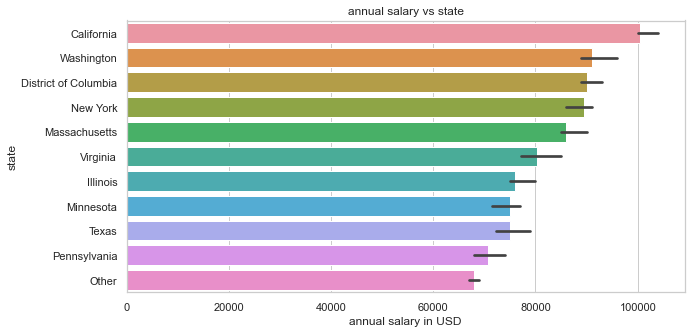

In [79]:
plot_categorical(survey,"state",10)

## annual_salary vs industry
- Next, let's look at industry. There is probably a relationship between the industry people are working in and their annual salary. The barplot gives suggestive evidence of this. I probably should train a regularized regression model using state, industry, (and a few other variables like years of experience) as predictors

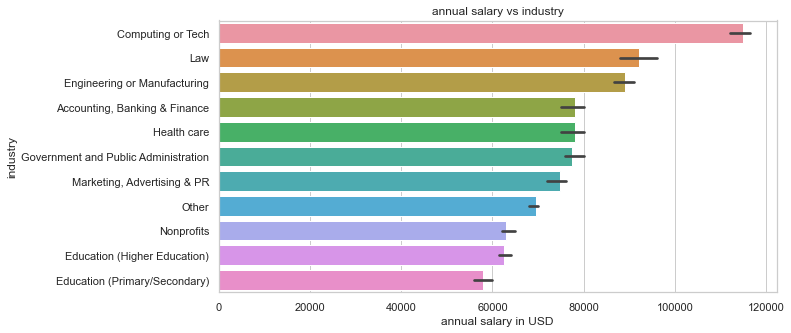

In [80]:
plot_categorical(survey,"industry",10)

## annual_salary vs job_title
- Senior SW engineer's median salary that is higher than Director! This most likely has to do with years of experience (need to control for that!) A Director at a startup likely will have lower salary on average than a Senior SWE with 15+ years experience at tech companies

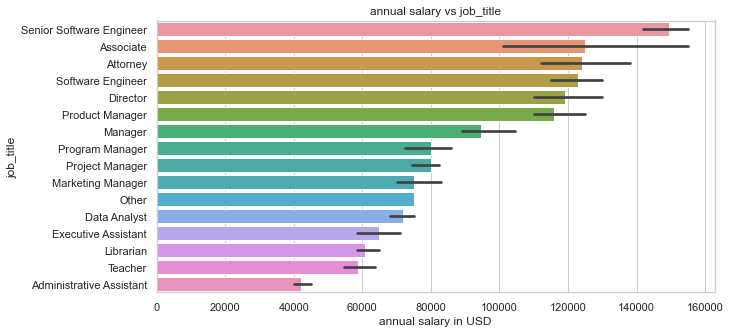

In [81]:
plot_categorical(survey,"job_title",15)

## annual_salary vs years of experience
- overall_years_of_professional_experience
- years_of_experience_in_field

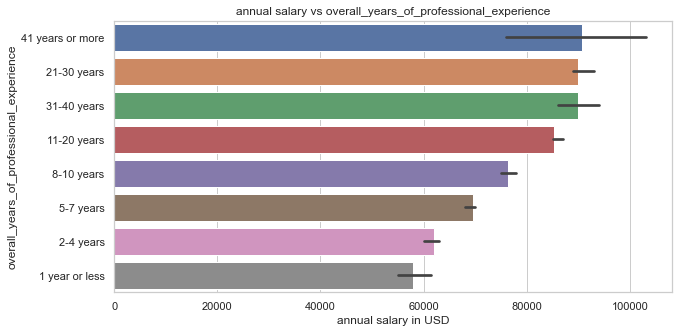

In [82]:
plot_categorical(survey_usd,"overall_years_of_professional_experience",10)

On the whole, annual salary increases with overall years of professional experience and years in field

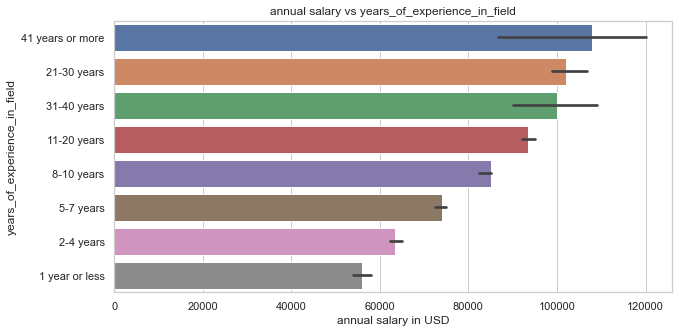

In [83]:
plot_categorical(survey_usd,"years_of_experience_in_field",10)

## Age, race, and education vs annual_salary

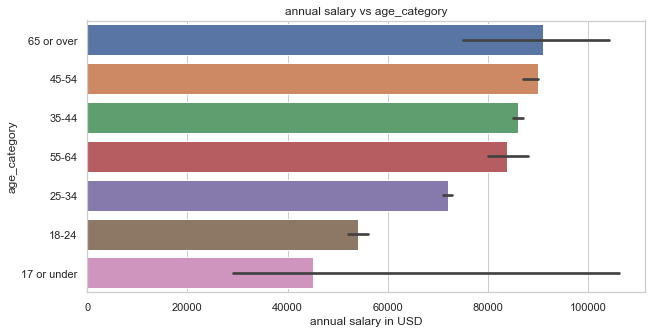

In [84]:
plot_categorical(survey_usd,"age_category",15)

Higher age categories is correlated with higher annual salary.

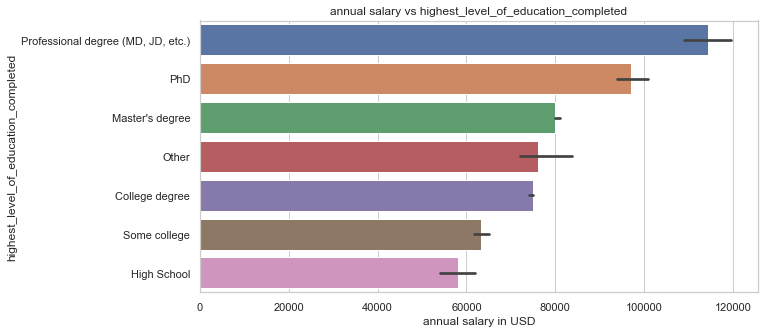

In [85]:
plot_categorical(survey_usd,"highest_level_of_education_completed",15)

Higher level of education is correlated with higher levels of salary

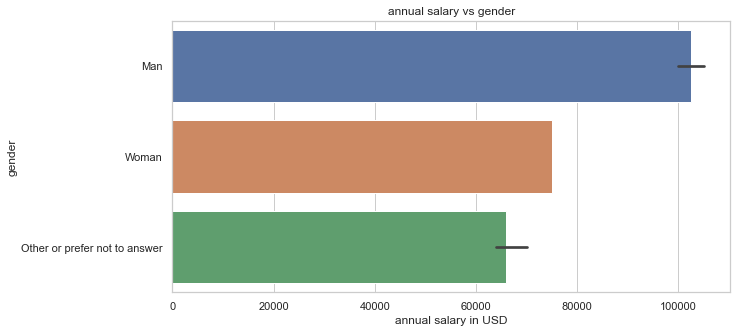

In [86]:
plot_categorical(survey_usd,"gender")

The result might suggest Man makes more than Woman, but it could also be confounded by education, and the types of jobs that man hold vs woman. 

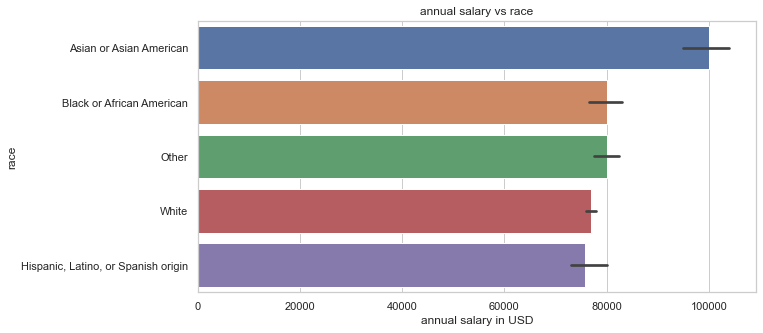

In [87]:
plot_categorical(survey_usd,"race")

Except for Asian or Asian American, which holds higher salary than the other races, all other races have similar median salary (might not be statistically different from each other).

## Let's check for interaction: for example, are there difference in the relationship between experience X annual salary across gender groups?

<AxesSubplot:xlabel='annual_salary', ylabel='years_of_experience_in_field'>

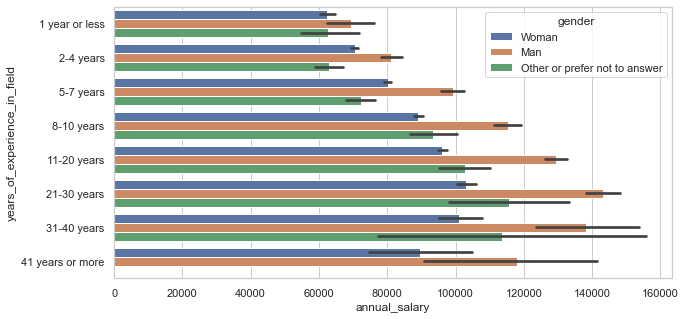

In [88]:
fig = plt.figure(figsize=(10,5))
ax=fig.add_subplot(1,1,1)

sns.barplot(
    x='annual_salary',
    y='years_of_experience_in_field',
    hue='gender',
    orient='h',
    axes=ax,
    data=survey_usd 
)

The gap in median salary across gender groups seems to widen with years of experience

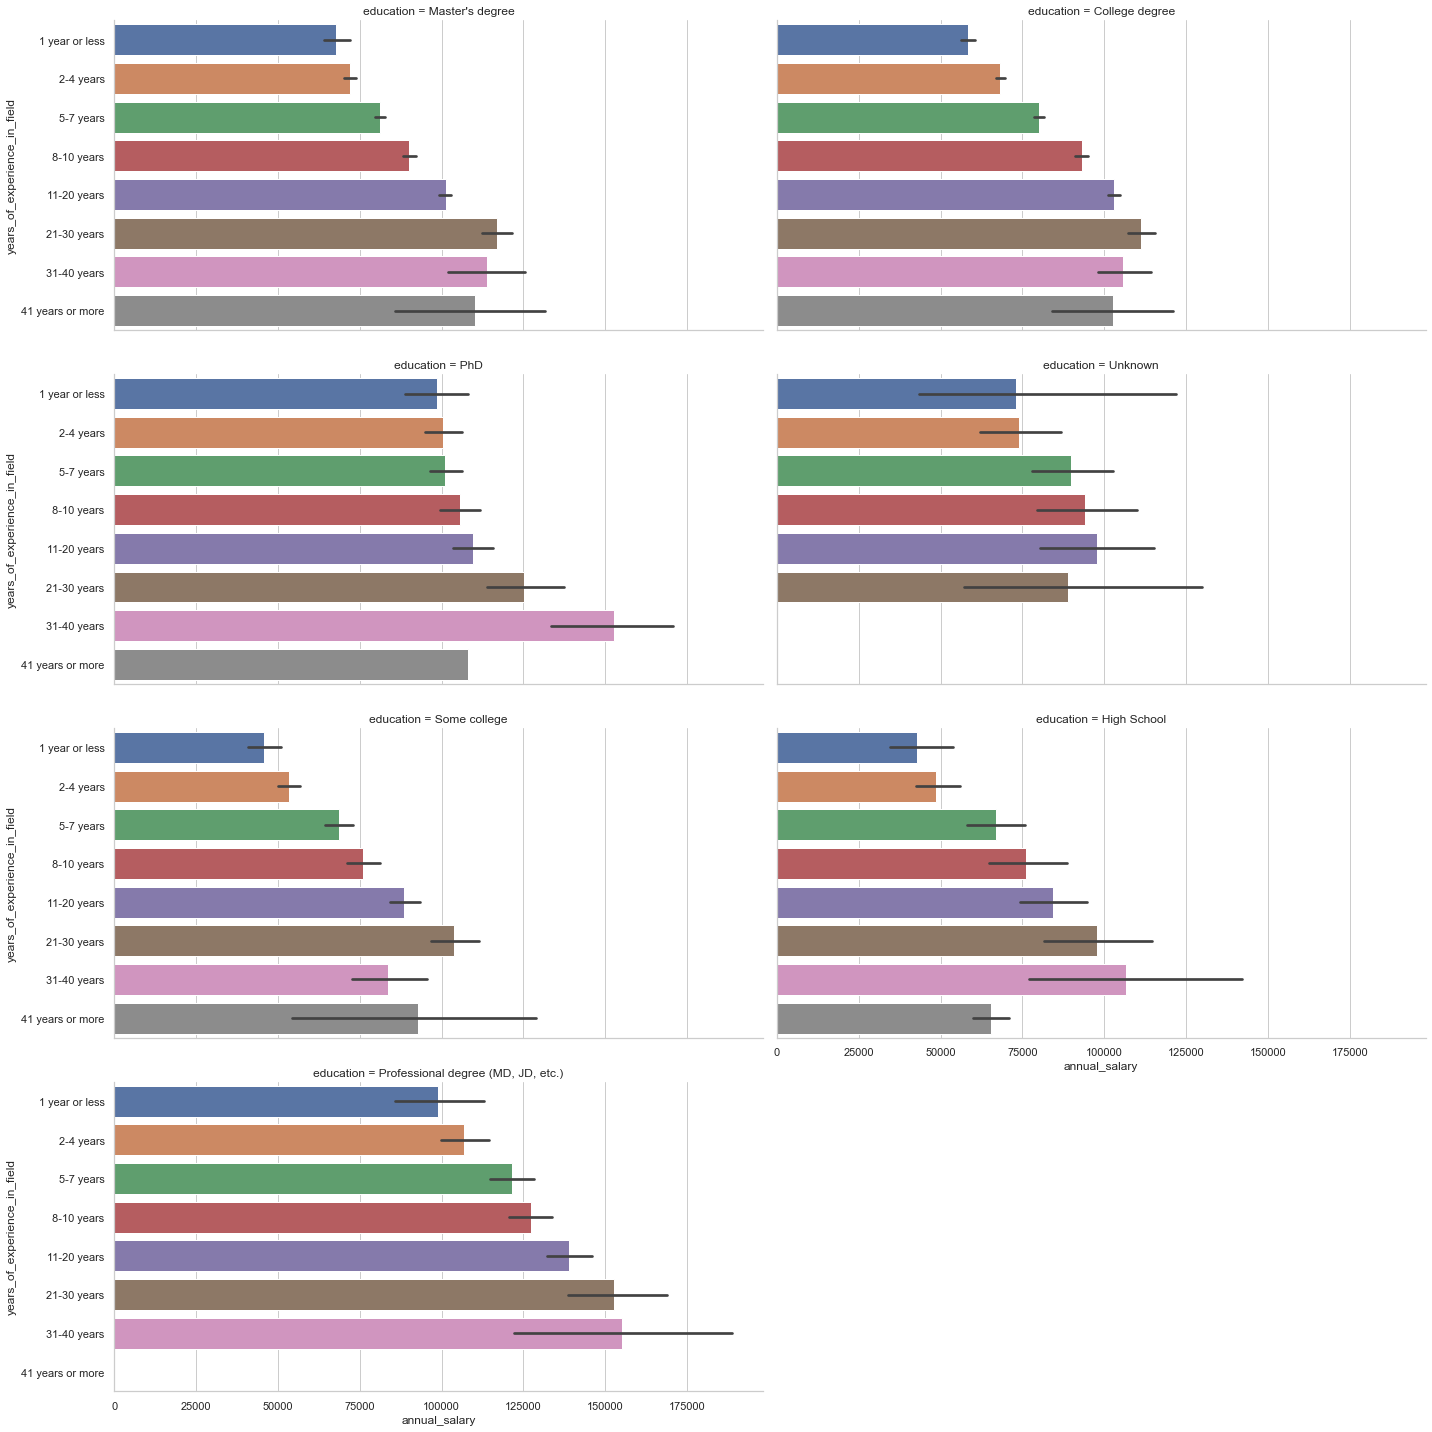

In [89]:
# sns.catplot do not have a axes parameter
# But you can set size of the figure with the height and aspect parameters
sns.catplot(
    x='annual_salary',
    y='years_of_experience_in_field',
    col='education',
    col_wrap=2,
    kind='bar',
    height=5,
    aspect=2,
    data=survey_usd 
)

Relationship between years of experience and annual salary is similar across all levels of education.

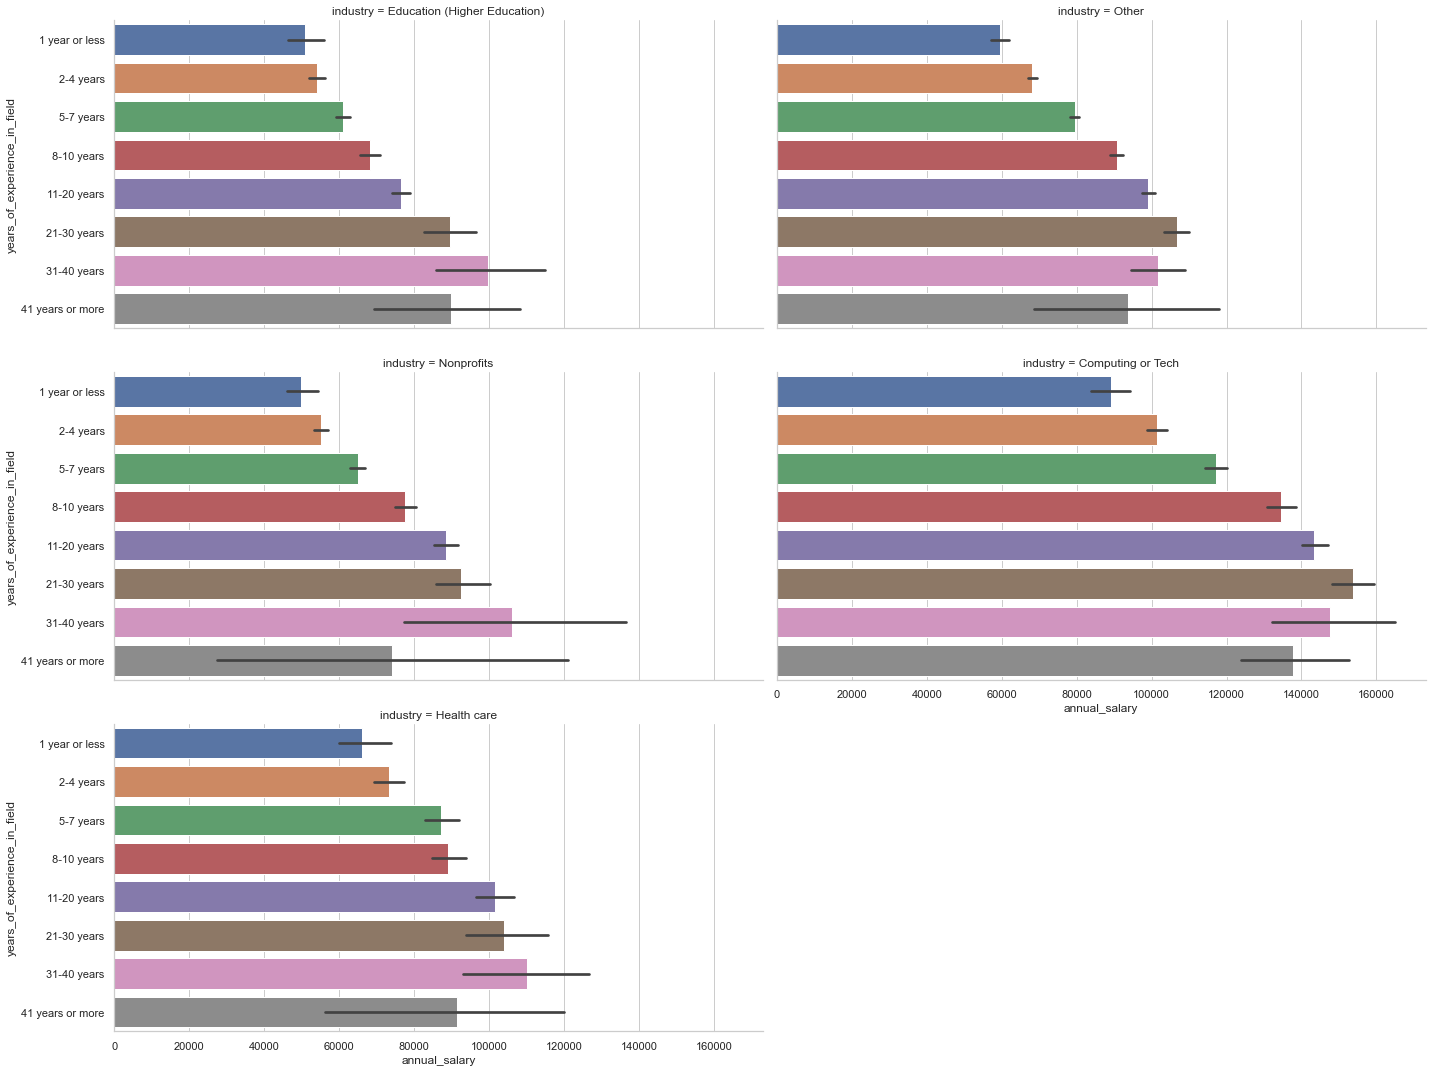

In [90]:
data = survey_usd.copy() # make a copy of input dataframe
    
# Lump rare levels in col to "Other"
data=fct_lump(df_in=data,
              col= "industry",
              n_retain=5)

sns.catplot(
    x='annual_salary',
    y='years_of_experience_in_field',
    col='industry',
    col_wrap=2,
    kind='bar',
    height=5,
    aspect=2,
    data=data 
)
    

In general, years of experience increases with experience for all industries, except for computing and tech after 21-30 years. 

## Identify collinear features
- Highly collinear features have a significant correlation coefficent between them. 
- It will lead to high standard deviation for the estimated regression coefficent in linear regression models (we are less certain about our estimated betas). But this is not a problem for tree-based methods like random forest regressor.
- Since all of our features are categorical, we need to use Cramer's V as a measure of correlation between pairs of categorical variables.

In [91]:
features_of_interest = ["age_category","industry","job_title","state","city",
                       "overall_years_of_professional_experience","years_of_experience_in_field",
                       "education","gender","race"]

In [92]:
# Get features of interest (excluding some variables like "additional conext of salary" 
# that we don't think should be included in the model)
features = survey_usd.loc[:,features_of_interest]

In [93]:
features.head()

,age_category,industry,job_title,state,city,overall_years_of_professional_experience,years_of_experience_in_field,education,gender,race
0,25-34,Education (Higher Education),Other,Massachusetts,Boston,5-7 years,5-7 years,Master's degree,Woman,White
2,25-34,"Accounting, Banking & Finance",Other,Other,Other,2-4 years,2-4 years,College degree,Woman,White
3,25-34,Nonprofits,Program Manager,Other,Other,8-10 years,5-7 years,College degree,Woman,White
4,25-34,"Accounting, Banking & Finance",Other,Other,Other,8-10 years,5-7 years,College degree,Woman,White
5,25-34,Education (Higher Education),Other,Other,Other,8-10 years,2-4 years,Master's degree,Man,White


In [94]:
# We need to label encode the categorical features


In [95]:
# Init a defaultdict that will contain the column name as key, and init LabelEncoder() 
# transformer as value (default value of the dictionary). Each of these LabelEncoder will be fitted and
# will be associated to its key (which is the column name)
d = defaultdict(LabelEncoder)

In [96]:
# Note: pd.Series.name gets the name of the series (name of the column in the dataframe)
labelled_features = features.apply(lambda x: d[x.name].fit_transform(x))

In [97]:
labelled_features

,age_category,industry,job_title,state,city,overall_years_of_professional_experience,years_of_experience_in_field,education,gender,race
0,2,2,13,3,0,6,6,2,2,4
2,2,0,13,6,6,2,2,0,2,4
3,2,9,16,6,6,7,6,0,2,4
4,2,0,13,6,6,7,6,0,2,4
5,2,2,13,6,6,7,2,2,0,4
...,...,...,...,...,...,...,...,...,...,...
26227,2,10,13,5,5,6,6,0,2,4
26228,3,9,13,7,6,1,2,0,2,0
26229,2,1,13,0,6,1,1,2,2,4
26230,2,8,13,10,9,2,2,0,2,4


**A few side notes**

In [98]:
# Dictionary of column names (key) and fitted LabelEncoder (value)
d

defaultdict(sklearn.preprocessing._label.LabelEncoder,
            {'age_category': LabelEncoder(),
             'industry': LabelEncoder(),
             'job_title': LabelEncoder(),
             'state': LabelEncoder(),
             'city': LabelEncoder(),
             'overall_years_of_professional_experience': LabelEncoder(),
             'years_of_experience_in_field': LabelEncoder(),
             'education': LabelEncoder(),
             'gender': LabelEncoder(),
             'race': LabelEncoder()})

In [99]:
# We can reverse the encoded if needed:
labelled_features.apply(lambda x: d[x.name].inverse_transform(x));

# We can use the dictionary of fitted LabelEncoder to transform (label) new data 
# df_test.apply(lambda x: d[x.name].transform(x))

**Building the Cramer's V matrix**

In [100]:
def cramers_V(var1,var2) :
    crosstab =np.array(pd.crosstab(var1,var2, rownames=None, colnames=None)) # Cross table building
    stat = chi2_contingency(crosstab)[0] # Keeping of the test statistic of the Chi2 test
    obs = np.sum(crosstab) # Number of observations
    mini = min(crosstab.shape)-1 # Take the minimum value between the columns and the rows of the cross table
    
    return (stat/(obs*mini))

In [106]:
rows= []

for var1 in labelled_features:
    col = []
    for var2 in labelled_features :
        cramers =cramers_V(labelled_features[var1], labelled_features[var2]) # Cramer's V test
        col.append(round(cramers,2)) # Keeping of the rounded value of the Cramer's V  
    rows.append(col)

cramers_results = np.array(rows)

In [107]:
df_cramer = pd.DataFrame(cramers_results, 
                         columns = labelled_features.columns, 
                         index =labelled_features.columns)

In [109]:
df_cramer

,age_category,industry,job_title,state,city,overall_years_of_professional_experience,years_of_experience_in_field,education,gender,race
age_category,1.00,0.00,0.00,0.00,0.00,0.26,0.15,0.01,0.00,0.00
industry,0.00,1.00,0.05,0.01,0.01,0.00,0.00,0.07,0.04,0.00
job_title,0.00,0.05,1.00,0.00,0.00,0.00,0.00,0.03,0.01,0.00
state,0.00,0.01,0.00,1.00,0.36,0.00,0.00,0.00,0.00,0.01
city,0.00,0.01,0.00,0.36,1.00,0.00,0.00,0.00,0.00,0.01
overall_years_of_professional_experience,0.26,0.00,0.00,0.00,0.00,1.00,0.28,0.01,0.00,0.01
years_of_experience_in_field,0.15,0.00,0.00,0.00,0.00,0.28,1.00,0.00,0.01,0.00
education,0.01,0.07,0.03,0.00,0.00,0.01,0.00,1.00,0.01,0.00
gender,0.00,0.04,0.01,0.00,0.00,0.00,0.01,0.01,1.00,0.01
race,0.00,0.00,0.00,0.01,0.01,0.01,0.00,0.00,0.01,1.00


## Heatmap

/var/folders/0t/47qwfn79375230vlpg79zkdh0000gn/T/ipykernel_36391/613395922.py:1: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(df_cramer, dtype=np.bool)


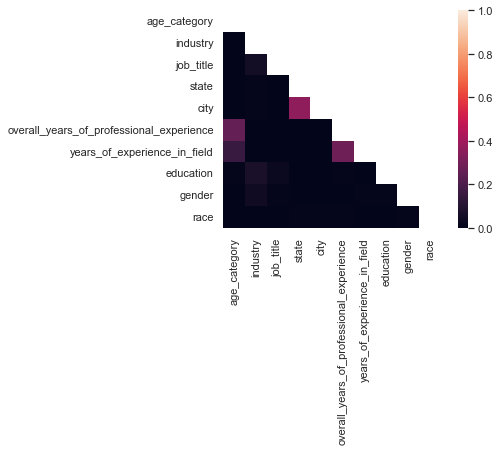

In [110]:
mask = np.zeros_like(df_cramer, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

with sns.axes_style("white"):
    ax = sns.heatmap(df_cramer, 
                     mask= mask,
                     vmin=0.0, 
                     vmax=1, 
                     square=True)

plt.show()

With the exception of city-state (Cramer's V 0.36), none of the feature pairs have correlation that exceeds 0.3. Even the two years of experience features only have Cramer's V of 0.28. We can start by including all of the above features into regression model and only reconsider dropping some features (e.g., city, or overall_years_of_professional_experience) if the VIF is very high for the linear regression model.